In [875]:
import tensorflow as tf
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns

file_path = "time_series_data/TSLA_time_series.csv"

df = pd.read_csv(file_path)
df

,datetime,open,high,low,close,volume,open-trend,open-change,high-trend,high-change,...,close-change,volume-trend,volume-change,percent_b,macd,macd_signal,macd_hist,adx,ema,rsi
0,2023-12-04 10:40:00,235.40,235.84,235.36,235.64,413183,1,NaN,1,NaN,...,NaN,1,NaN,0.50,-0.44,-0.50,0.06,25.86,235.37,45.50
1,2023-12-04 10:41:00,235.64,235.70,235.28,235.41,256584,1,NaN,1,NaN,...,NaN,1,NaN,0.41,-0.41,-0.48,0.08,24.70,235.38,42.07
2,2023-12-04 10:42:00,235.39,235.44,235.07,235.15,263342,1,NaN,1,NaN,...,NaN,1,NaN,0.29,-0.40,-0.46,0.07,24.07,235.33,38.68
3,2023-12-04 10:43:00,235.14,235.34,234.90,235.24,301437,1,NaN,1,NaN,...,NaN,1,NaN,0.36,-0.38,-0.45,0.07,23.83,235.31,40.47
4,2023-12-04 10:44:00,235.20,235.37,235.02,235.12,218101,1,NaN,1,NaN,...,NaN,1,NaN,0.31,-0.37,-0.43,0.06,23.52,235.28,38.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2023-12-20 15:55:00,247.88,248.00,247.70,247.71,536344,0,-1.40,0,-1.32,...,-1.45,1,273148.0,-0.12,-0.29,-0.18,-0.11,17.58,248.34,31.59
4996,2023-12-20 15:56:00,247.70,247.94,247.64,247.70,385095,0,-1.45,0,-1.26,...,-1.15,1,87727.0,-0.02,-0.33,-0.21,-0.12,19.17,248.21,31.50
4997,2023-12-20 15:57:00,247.70,247.77,247.10,247.18,630399,0,-1.15,0,-1.27,...,-1.75,1,297794.0,-0.12,-0.40,-0.25,-0.15,21.46,248.01,26.37
4998,2023-12-20 15:58:00,247.16,247.44,247.15,247.19,491915,0,-1.79,0,-1.70,...,-1.43,1,188475.0,-0.01,-0.45,-0.29,-0.16,23.59,247.84,26.62


In [876]:
df.index = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.drop(["datetime"], axis=1, inplace=True)
df['day_of_week'] = df.index.day_of_week
df['hour'] = df.index.hour
target_column = df['open-trend']
test_size = 0.2
forward_lead = 10
df['target'] = target_column.shift(-1)
df = df.iloc[forward_lead:]
df

,open,high,low,close,volume,open-trend,open-change,high-trend,high-change,low-trend,...,percent_b,macd,macd_signal,macd_hist,adx,ema,rsi,day_of_week,hour,target
datetime,,,,,,,,,,,,,,,,,,,,,
2023-12-04 10:50:00,235.00,235.00,234.50,234.51,330940,0,-0.40,0,-0.84,0,...,0.07,-0.38,-0.39,0.01,25.43,234.90,33.65,0,10,0.0
2023-12-04 10:51:00,234.50,234.89,234.35,234.83,389369,0,-1.14,0,-0.81,0,...,0.33,-0.36,-0.39,0.02,26.14,234.89,40.79,0,10,0.0
2023-12-04 10:52:00,234.88,235.07,234.65,234.94,279527,0,-0.51,0,-0.37,0,...,0.43,-0.34,-0.38,0.04,26.12,234.90,42.95,0,10,0.0
2023-12-04 10:53:00,234.92,234.92,234.35,234.57,314811,0,-0.22,0,-0.42,0,...,0.14,-0.34,-0.37,0.03,26.69,234.83,37.77,0,10,0.0
2023-12-04 10:54:00,234.53,234.55,234.01,234.10,458514,0,-0.67,0,-0.82,0,...,-0.12,-0.38,-0.37,-0.01,27.79,234.69,32.42,0,10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20 15:55:00,247.88,248.00,247.70,247.71,536344,0,-1.40,0,-1.32,0,...,-0.12,-0.29,-0.18,-0.11,17.58,248.34,31.59,2,15,0.0
2023-12-20 15:56:00,247.70,247.94,247.64,247.70,385095,0,-1.45,0,-1.26,0,...,-0.02,-0.33,-0.21,-0.12,19.17,248.21,31.50,2,15,0.0
2023-12-20 15:57:00,247.70,247.77,247.10,247.18,630399,0,-1.15,0,-1.27,0,...,-0.12,-0.40,-0.25,-0.15,21.46,248.01,26.37,2,15,0.0


In [877]:
index = 1290

for i in range(index, index + forward_lead):
    current_open_price = df.iloc[i + forward_lead]["open"]
    current_open_trend = df.iloc[i + forward_lead]["open-trend"]
    current_open_change = df.iloc[i + forward_lead]["open-change"]
    old_open_price = df.iloc[i]["open"]
    trend_from_last_entry = df.iloc[i + forward_lead -1]["target"]
    print(f"Current: {current_open_price}, Old: {old_open_price}, Trend: {current_open_trend}, Change: {current_open_change}, last trend: {trend_from_last_entry}")


Current: 240.51, Old: 239.98, Trend: 1.0, Change: 0.53, last trend: 1.0
Current: 240.43, Old: 240.0, Trend: 1.0, Change: 0.43, last trend: 1.0
Current: 240.43, Old: 239.66, Trend: 1.0, Change: 0.77, last trend: 1.0
Current: 240.45, Old: 240.04, Trend: 1.0, Change: 0.41, last trend: 1.0
Current: 240.45, Old: 240.18, Trend: 1.0, Change: 0.27, last trend: 1.0
Current: 240.35, Old: 240.35, Trend: 0.0, Change: 0.0, last trend: 0.0
Current: 240.98, Old: 240.64, Trend: 1.0, Change: 0.34, last trend: 1.0
Current: 241.04, Old: 240.64, Trend: 1.0, Change: 0.4, last trend: 1.0
Current: 240.96, Old: 240.75, Trend: 1.0, Change: 0.21, last trend: 1.0
Current: 241.08, Old: 240.66, Trend: 1.0, Change: 0.42, last trend: 1.0


In [878]:
def get_recent_time_series_batch() -> tuple:
    seq_length: int = 10
    target_column_name: str = "target"
    time_series_batch = []
    time_series_target = []

    for row in range(len(df) - seq_length):
        time_series_batch.append(df.iloc[row:row + seq_length].values)
        time_series_target.append(df[target_column_name].iloc[row + seq_length - 1])

    time_series_batch = np.array(time_series_batch)
    time_series_target= np.array(time_series_target)
    return time_series_batch, time_series_target

X, y = get_recent_time_series_batch()

"""
X is a list with contains (len(df) - seq_length) entries. The first entry is a list of the first seq_length rows of df. X[index][-1] gives you the (index + seq_length)-th row of df.
y is a list that contains (len(df) - seq_length) entries. The first entry is the "target" column of the seq_length row. X[index][-1][-1] and y[index] are the same "target" value.
If df has 5000 entries, X.shape y.shape will give you: ((4980, 10, 25), (4980,))
"""
X.shape, y.shape

((4980, 10, 25), (4980,))

In [879]:
# Split the data into training and temporary sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Further split the temporary set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=test_size, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Print the shapes of the sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (3187, 10, 25) (3187,)
Validation set shape: (797, 10, 25) (797,)
Test set shape: (996, 10, 25) (996,)


In [880]:
from keras.src.layers import LSTM, Dropout, Dense
from keras import Sequential

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/30
100/100 [==============================] - 3s 11ms/step - loss: 0.6589 - accuracy: 0.6404 - val_loss: 0.5960 - val_accuracy: 0.7654
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.5655 - accuracy: 0.7596 - val_loss: 0.5184 - val_accuracy: 0.7867
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.5042 - accuracy: 0.7800 - val_loss: 0.4633 - val_accuracy: 0.8206
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4532 - accuracy: 0.8083 - val_loss: 0.4154 - val_accuracy: 0.8457
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4029 - accuracy: 0.8412 - val_loss: 0.3702 - val_accuracy: 0.8657
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3633 - accuracy: 0.8607 - val_loss: 0.3358 - val_accuracy: 0.8770
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3303 - accuracy: 0.8761 - val_loss: 0.3094 - val_accuracy: 0.8871
Epoch

32/32 [==============================] - 0s 2ms/step - loss: 0.0761 - accuracy: 0.9930
Test Loss: 0.0761, Test Accuracy: 99.30%


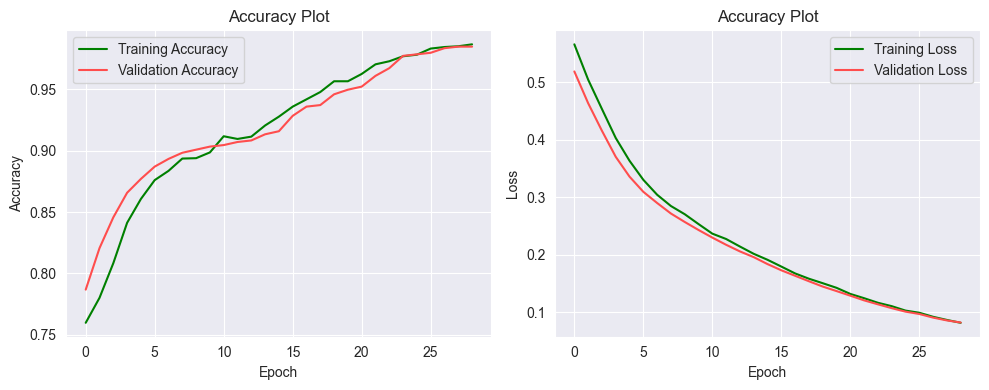

In [881]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(history.history['accuracy'][1:], label='Training Accuracy', color="green")
ax1.plot(history.history['val_accuracy'][1:], label='Validation Accuracy', color="#ff4d4d")

ax1.set_title('Accuracy Plot')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'][1:], label='Training Loss', color="green")
ax2.plot(history.history['val_loss'][1:], label='Validation Loss', color="#ff4d4d")

ax2.set_title('Accuracy Plot')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [882]:
y_pred_prob = model.predict(X_test)
y_red_prob = scaler.inverse_transform(y_pred_prob)
y_pred = (y_pred_prob > 0.5).astype(int)

y_actual = y_test
results_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred.flatten(), 'Predicted_Prob': y_pred_prob.flatten()})
results_df

32/32 [==============================] - 0s 3ms/step


ValueError: non-broadcastable output operand with shape (996,1) doesn't match the broadcast shape (996,25)

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(4, 4))

group_names = ["True Neg.","False Pos.","False Neg.","True Pos."]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Reds', cbar=True,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()